In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
torch.cuda.is_available()

False

## Loading data

PyTorch has two primitives to work with data: 
- `torch.utils.data.Dataset` - Stores the samples and their corresponding labels
- `torch.utils.data.DataLoader` - Wraps an iterable around the Dataset.

PyTorch offers domain-specific libraries such as 
- TorchText
- TorchVision
- TorchAudio
all of which include datasets. 

For this notebook, we will be using a TorchVision dataset. [List of vision data sets](https://pytorch.org/vision/stable/datasets.html)

In [4]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:05<00:00, 4.45MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 2.13MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 23.3MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.9MB/s]


In [8]:
isinstance(training_data, Dataset)

True

In [5]:
# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [9]:
isinstance(test_data, Dataset)

True

In [ ]:
batch_size = 64

# Create data loaders. These are iterators over the datasets passed as arguments
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [47]:
from torch.utils.data import Subset

In [48]:
# Get the indices for the first batch
batch_size = train_dataloader.batch_size
subset_indices = range(batch_size)  # Select the first `batch_size` samples
subset_indices

range(0, 64)

In [49]:
subset = Subset(train_dataloader.dataset, subset_indices)
subset

In [51]:
single_batch_dataloader = DataLoader(subset, batch_size=batch_size)
len(single_batch_dataloader)

1

In [ ]:
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

In [37]:
len(train_dataloader)

938

In [43]:
train_dataloader

In [ ]:
len(train_dataloader)

938

[Source on datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [16]:
for x in test_dataloader:
    print(len(x))
    print(type(x))
    print(type(x[0]))
    break

2
<class 'list'>
<class 'torch.Tensor'>


In [11]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


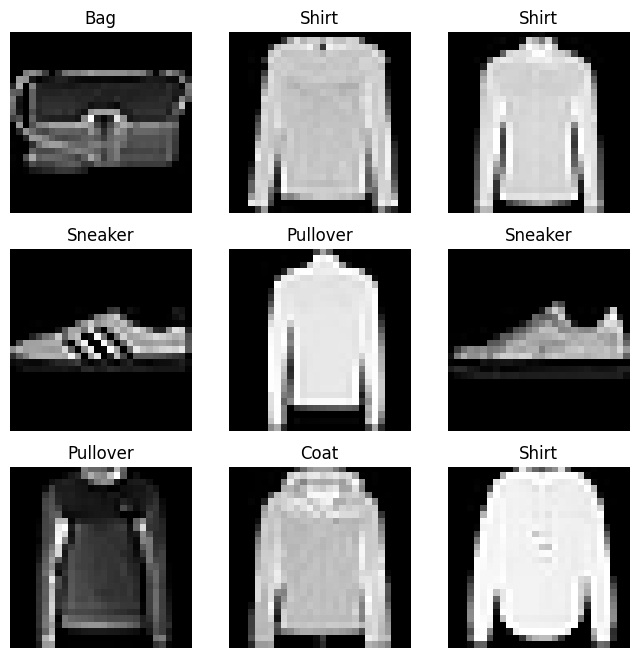

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating a NN

[Source on building a NN in pytorch](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

In [22]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512), nn.ReLU(), nn.Linear(512, 512), nn.ReLU(), nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To train a model, we need a [`loss function`](https://pytorch.org/docs/stable/nn.html#loss-functions) and an [`optimizer`](https://pytorch.org/docs/stable/optim.html).

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# check the model’s performance against the test dataset to ensure it is learning.
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [31]:
len(train_dataloader.dataset)

60000

In [30]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305721  [   64/60000]
loss: 2.293871  [ 6464/60000]
loss: 2.274062  [12864/60000]
loss: 2.265851  [19264/60000]
loss: 2.254865  [25664/60000]
loss: 2.212093  [32064/60000]
loss: 2.223943  [38464/60000]
loss: 2.188038  [44864/60000]
loss: 2.176205  [51264/60000]
loss: 2.138261  [57664/60000]
Test Error: 
 Accuracy: 47.1%, Avg loss: 2.141611 

Epoch 2
-------------------------------
loss: 2.148989  [   64/60000]
loss: 2.139051  [ 6464/60000]
loss: 2.084359  [12864/60000]
loss: 2.097684  [19264/60000]
loss: 2.041920  [25664/60000]
loss: 1.977024  [32064/60000]
loss: 2.005071  [38464/60000]
loss: 1.924753  [44864/60000]
loss: 1.923359  [51264/60000]
loss: 1.840560  [57664/60000]
Test Error: 
 Accuracy: 54.5%, Avg loss: 1.849202 

Epoch 3
-------------------------------
loss: 1.881832  [   64/60000]
loss: 1.849076  [ 6464/60000]
loss: 1.740026  [12864/60000]
loss: 1.780052  [19264/60000]
loss: 1.659387  [25664/60000]
loss: 1.620247  [32064/600

## 1. Training Function
The `train` function performs the following steps for each batch:
1. Sets the model to training mode with `model.train()`.
2. Moves the input data (`X`) and labels (`y`) to the appropriate device (CPU/GPU).
3. Computes predictions using `model(X)`.
4. Calculates the loss with `loss_fn(pred, y)`.
5. Performs backpropagation with `loss.backward()`.
6. Updates model parameters using `optimizer.step()`.
7. Resets gradients with `optimizer.zero_grad()`.
8. Logs progress every 100 batches.

## 2. Testing Function
The `test` function evaluates the model on the test dataset:
1. Sets the model to evaluation mode with `model.eval()`.
2. Disables gradient computation with `torch.no_grad()`.
3. Computes predictions and accumulates the loss and accuracy.
4. Prints the average loss and accuracy after evaluation.

## 3. Device Setup
The `device` is set to use a GPU if available, otherwise it defaults to the CPU.

## 4. Model Definition
A simple feedforward neural network is defined with:
1. A `Flatten` layer to convert 2D input (e.g., 28x28 images) into a 1D vector.
2. A hidden layer with 512 neurons and ReLU activation.
3. An output layer with 10 neurons (for 10 classes).

## 5. Loss Function and Optimizer
The `CrossEntropyLoss` is used for multi-class classification, and the `SGD` optimizer updates model parameters with a learning rate of \(1 \times 10^{-3}\).

## 6. Training and Testing Loop
The model is trained and evaluated for 5 epochs:
1. For each epoch, the `train` function updates the model's parameters.
2. The `test` function evaluates the model on the test dataset.
3. Progress is logged after each epoch, showing the loss, accuracy, and other metrics.

## 7. Output
- During training, the loss is logged every 100 batches.
- During testing, the accuracy and average loss are logged after each epoch.
- After all epochs, the script prints "Done!".


## Saving & Loading model

[More reading](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html)

In [ ]:
torch.save(model.state_dict(), "models/model.pth")
print("Saved PyTorch Model State to models/model.pth")

Saved PyTorch Model State to model.pth


In [33]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("models/model.pth", weights_only=True))

<All keys matched successfully>

## Prediction

In [34]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## Tensors

In [ ]:
# Directly from data
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)
x_data

tensor([[1, 2],
        [3, 4]])

In [55]:
# From numpy
np_array = np.array(data)
x_np = torch.from_numpy(np_array)
x_np

tensor([[1, 2],
        [3, 4]])

In [ ]:
# From another tensor
x_ones = torch.ones_like(x_data)  # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float)  # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.2672, 0.7750],
        [0.1129, 0.8991]]) 



In [ ]:
# with random or constant values
shape = (
    2,
    3,
)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.2904, 0.1473, 0.8182],
        [0.6283, 0.9760, 0.2990]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [ ]:
# Attributes
tensor = torch.rand(3, 4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


### Tensor operations

In [63]:
# We move our tensor to the current accelerator if available
if torch.accelerator.is_available():
    tensor = tensor.to(torch.accelerator.current_accelerator())

print(f"Device tensor is stored on: {tensor.device}")

Device tensor is stored on: mps:0


In [ ]:
# Indexing and slicing
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:, 1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
